# 0 - Information

In [ ]:
# Re tester l'upload de l'entraiment du réseau de neurones avec les paramètres sans dropout
# Test un benchmark avec le carré de la distance comme diviseur.

# 1 - Packages

In [1]:
# Math packages
import numpy as np

# Dataset packages
import pandas as pd
import copy

# Graphic package
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Os packages
import os, sys

# Time packages
import time

# Sklearn packages
import sklearn.svm as svm
import sklearn.linear_model as sklin
import sklearn.model_selection as mod_selec
import sklearn.metrics as metrics

# Keras
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization
from keras.optimizers import SGD
from keras.utils import np_utils

# Lightlgb
import lightgbm as lgb

# Progress bar
import tqdm as tqdm

Using TensorFlow backend.


# 2 - Loading of the Data

## 2.1 - Extrat all the data

In [2]:
# Loading of the data
X_train_df = pd.read_csv("Data/X_train.csv")
Y_train_df = pd.read_csv("Data/Y_train.csv")
X_test_df = pd.read_csv("Data/X_test.csv")

# Display
print("Columns names: ", X_train_df.columns)
print("Shape: ", X_train_df.shape)
X_train_df.head()

Columns names:  Index(['ID', 'station_id', 'hdres_100', 'hdres_500', 'ldres_100', 'ldres_500',
       'industry_100', 'industry_500', 'urbgreen_100', 'urbgreen_500',
       'roads_length_25', 'roads_length_100', 'roads_length_500',
       'major_roads_length_25', 'major_roads_length_100',
       'major_roads_length_500', 'distance_0', 'distance_1', 'distance_2',
       'distance_3', 'distance_4', 'distance_5', 'distance_6', 'distance_7',
       'distance_8', 'distance_9', 'value_0', 'value_1', 'value_2', 'value_3',
       'value_4', 'value_5', 'value_6', 'value_7', 'value_8', 'value_9'],
      dtype='object')
Shape:  (695255, 36)


,ID,station_id,hdres_100,hdres_500,ldres_100,ldres_500,industry_100,industry_500,urbgreen_100,urbgreen_500,...,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9
0,0,105,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,53.0,46.0,52.0,44.0,40.0,38.0,54.0,36.0,39.0,42.0
1,1,105,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,55.0,47.0,54.0,45.0,41.0,39.0,55.0,37.0,40.0,43.0
2,2,105,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,84.5,54.0,78.0,49.0,47.0,42.0,63.0,42.0,48.0,49.0
3,3,105,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,97.0,59.0,84.0,55.0,58.0,48.0,72.0,51.0,57.0,59.0
4,4,105,0.0,0.0,1.0,0.929,0.0,0.033,0.0,0.022,...,99.0,67.0,95.0,63.0,67.0,48.0,82.0,59.0,64.0,65.0


## 2.2 - Replace Nan value by interpolation

In [3]:
def fillNan(df, method="linear"):
    """Fill Nan values of X_train of X_test with an interpolation."""

    # Interpolate the missing value thanks to interpolation for each station_id
    columns_to_interpolate = ["value_" + str(i) for i in range(10)]

    # Group samples by station_id
    g_stations_df = df.groupby(["station_id"])

    # Loop over the different groups
    for station_id, g in g_stations_df:

        # Interpolate the value of columns_to_interpolate
        values = g[columns_to_interpolate]
        values.interpolate(inplace=True, method=method,
                           limit_direction='forward', axis=0)
        values.interpolate(inplace=True, method=method,
                           limit_direction='backward', axis=0)

        # Replace the values of df
        df.loc[g.index, columns_to_interpolate] = values.values
    
    return df

In [4]:
# Check the number of Nan values of X_train_df
print("Before Fill Nan: ", X_train_df.isna().sum())

# Fill Nan of X_train and X_test
X_train_df = fillNan(X_train_df)
X_test_df = fillNan(X_test_df)

# Fill Nan with the mean
# X_train_df.fillna(X_train_df.mean(), inplace=True)
# X_test_df.fillna(X_test_df.mean(), inplace=True)

# Fill Nan with 0
# X_train_df.fillna(0, inplace=True)
# X_test_df.fillna(0, inplace=True)

# Drop rows with NaN
# X_train_df.dropna(inplace=True)
# X_test_df.dropna(inplace=True)
# Y_train_df = Y_train_df.loc[X_train_df.index, :]
# print("New Shape: ", X_train_df.shape, Y_train_df.shape)
    
# Check the number of Nan values of X_train_df
X_train_df.isna().sum()

Before Fill Nan:  ID                            0
station_id                    0
hdres_100                     0
hdres_500                     0
ldres_100                     0
ldres_500                     0
industry_100                  0
industry_500                  0
urbgreen_100                  0
urbgreen_500                  0
roads_length_25               0
roads_length_100              0
roads_length_500              0
major_roads_length_25         0
major_roads_length_100        0
major_roads_length_500        0
distance_0                    0
distance_1                    0
distance_2                    0
distance_3                    0
distance_4                    0
distance_5                    0
distance_6                    0
distance_7                    0
distance_8                    0
distance_9                    0
value_0                   21605
value_1                   30245
value_2                   20751
value_3                   13919
value_4               

/home/pierre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/pierre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ID                        0
station_id                0
hdres_100                 0
hdres_500                 0
ldres_100                 0
ldres_500                 0
industry_100              0
industry_500              0
urbgreen_100              0
urbgreen_500              0
roads_length_25           0
roads_length_100          0
roads_length_500          0
major_roads_length_25     0
major_roads_length_100    0
major_roads_length_500    0
distance_0                0
distance_1                0
distance_2                0
distance_3                0
distance_4                0
distance_5                0
distance_6                0
distance_7                0
distance_8                0
distance_9                0
value_0                   0
value_1                   0
value_2                   0
value_3                   0
value_4                   0
value_5                   0
value_6                   0
value_7                   0
value_8                   0
value_9             

## 2.3 - Add the inverse of the distance

In [5]:
def inverse(x):
    """Compute the inverse of x if x not null."""
    
    if x != 0:
        return 1 / x
    else:
        return 10e10

# Loop over all columns of distance
for i in range(10):
    
    # Compute new columns
    X_train_df["inv_distance_" + str(i)] = X_train_df["distance_" + str(i)].apply(
                                                lambda x: inverse(x))
    X_test_df["inv_distance_" + str(i)] = X_test_df["distance_" + str(i)].apply(
                                                lambda x: inverse(x))

## 2.4 - Add the Benchmark

In [6]:
def addBenchmark(df):
    """Add benchmark to df."""
    
    # Compute the inverse of the distance
    distance_inv = (1. / df.filter(regex='^distance*', axis = 1)).values

    # Extract the value at the nearest station
    values = df.filter(regex='value_*', axis = 1)
    
    # Compute the benchmark
    numer = (distance_inv * values).sum(axis = 1)
    denom = (distance_inv * (values != 0)).sum(axis = 1)
    
    # Compute the benchmark
    benchmark = numer / denom
    df["Benchmark"] = benchmark

In [ ]:
def addBenchmark2(df):
    """Add benchmark with the squares of the distances to df."""
    
    # Compute the inverse of the distance
    distance_inv = (1. / df.filter(regex='^distance*', axis = 1)).values

    # Extract the value at the nearest station
    values = df.filter(regex='value_*', axis = 1)
    
    # Compute the benchmark
    numer = (distance_inv ** 2 * values).sum(axis = 1)
    denom = (distance_inv ** 2 * (values != 0)).sum(axis = 1)
    
    # Compute the benchmark
    benchmark = numer / denom
    df["Benchmark2"] = benchmark
    
    return df

In [7]:
# Add the benchmark to the dataFrames
addBenchmark(X_train_df)
addBenchmark(X_test_df)

## 2.5 - Add the Squares of the values in df

In [ ]:
def addSquares(df):
    """Add the square of the values of all columns."""

    # Extract all columns of df
    columns = df.filter(regex='^distance*', axis = 1).columns

    # Loop over all column in columns
    for col in columns:

        # Add the square
        df[col + str("^2")] = df[col] ** 2

    return df

In [ ]:
# Add the benchmark to the dataFrames
addSquares(X_train_df)
addSquares(X_test_df)

## 2.6 - Clipping of the value between 0 and 100

In [ ]:
def clipping(df, lower=0, upper=100):
    """Clipping of the value between 0 and 100."""
    
        # Extract all columns of df
    columns = df.filter(regex='^value*', axis = 1).columns

    # Loop over all column in columns
    df[columns].clip(lower=lower, upper=upper, inplace=True, axis=0)

    return df

In [ ]:
# Clip the value of the dataFrame
X_train_df = clipping(X_train_df)
X_test_df = clipping(X_test_df)

## 2.7 - Remove High Value

In [ ]:
def removeHighValue(x_df, y_df):
    """Remove high value from df."""
    
    # Extract index of low value
    x_df["max"] = x_df.filter(regex='^value*', axis = 1).max(axis=1)
    index_low_values = x_df[x_df["max"] > 100].index
    
    # Extract only low value
    x_df = x_df.loc[index_low_values, :]
    y_df = y_df.loc[index_low_values, :]
    
    return x_df, y_df

In [ ]:
# Remove high value
removeHighValue(X_train_df, Y_train_df);

## 2.* - Extract a same number of samples of each stations

In [8]:
# Number of stations
print("Number of stations: ", len(X_train_df["station_id"].unique()))
print("Number of samples per stations: ", X_train_df.groupby(["station_id"]).\
                                           apply(lambda g: len(g["hdres_100"])))

Number of stations:  85
Number of samples per stations:  station_id
0      8639
2      8779
3      8779
4      8779
5      3961
6      8675
7      8601
8      8309
9      8436
10     8534
11     8464
14     8649
15     8257
16     8478
17     8045
18     7055
19     8675
20     8502
21     8618
22     6468
23     8768
24     8747
25     8726
26     8688
28     8779
30     8779
32     8599
34     8779
35     8766
37     8549
       ... 
76     8185
77     8175
78     8779
80     8779
82     6468
83     8779
85     8779
86     8779
87     8779
88     8779
89     6417
90     6438
92     6397
93     8779
94     8779
95     7921
96     2118
97     6468
99     8779
100    8779
102    8779
104    8779
105    8779
106    8779
108    8779
109    8528
110    8185
111    8228
113    4591
114    8228
Length: 85, dtype: int64


In [8]:
# Initialisation of the seed
np.random.seed(42)

# Proportion of samples to extract from each station
p = 0.75

# Loop to compute the lines to extract
lines_train = []
lines_test = []
g_stations_df = X_train_df.groupby(["station_id"])

# Loop over the different groups
for station_id, g in g_stations_df:
    
    # Extract the index of the current group
    idx = np.array(g.index)
    
    # Shuffle of idx
    np.random.shuffle(idx)
    
    # Extract a random proportion p of idx
    n = len(idx)
    n_p = int(n * p)
    lines_train.extend(idx[:n_p])
    lines_test.extend(idx[n_p:])
    
# Extract the samples in X_train_df and Y_train_df
X_train_sub_train_df = X_train_df.loc[lines_train, :]
Y_train_sub_train_df = Y_train_df.loc[lines_train, :]
X_train_sub_test_df = X_train_df.loc[lines_train, :]
Y_train_sub_test_df = Y_train_df.loc[lines_train, :]

# New length
print("Shape: ", X_train_sub_train_df.shape)

Shape:  (521412, 47)


## 2.* - Extract values a numpy array

In [9]:
# Extract all tables as numpy array
X_train = X_train_df.iloc[:, 2:].values
X_test = X_test_df.iloc[:, 2:].values
y_train = Y_train_df.loc[:, "value"].values

# Extract sub tables as numpy array
X_train_sub_train = X_train_sub_train_df.iloc[:, 2:].values
y_train_sub_train = Y_train_sub_train_df.loc[:, "value"].values
X_train_sub_test = X_train_sub_test_df.iloc[:, 2:].values
y_train_sub_test = Y_train_sub_test_df.loc[:, "value"].values

# 3 - Model

## 3.1 - SVM

In [ ]:
# Hyper-parameter of the SVM
hp_svm = {"kernel": ['poly', 'rbf'],
          "gamma": ['scale'],
          "C": [1],           # [10 ** (i) for i in np.linspace(-5, 5, 10)]
          "epsilon": [0.1]}   # [10 ** (i) for i in np.linspace(-5, 5, 10)]

# SVM model
svm_model = svm.SVR()

## 3.2 - LASSO

In [ ]:
# Hyper-parameter of the SVM
hp_lasso = {"alpha": [10],
            "fit_intercept": [False],
            "normalize": [True]
           }

# SVM model
lasso_model = sklin.Lasso()

# 4 - GridSearch

## 4.1 - Apply the GridSearch

In [ ]:
# Metrics
loss = metrics.mean_squared_error # mean_squared_log_error
scoring = metrics.make_scorer(loss, greater_is_better=False)

# Apply the gridSearch
model = lasso_model # svm_model
model_name = "Lasso" # SVM
hp = hp_lasso # hp_svm
gds = mod_selec.GridSearchCV(model, hp, scoring=scoring, cv=5, error_score="raise",
                             verbose=1, n_jobs=-1)

In [ ]:
# Fiting of the GridSearch
gds.fit(X_train, y_train)

# Display best score and best params
print("Display best score: ", gds.best_score_)
print("Display best params: ", gds.best_params_)

## 4.2 - Make Predictions

In [ ]:
# Make predictions
y_pred_values = gds.predict(X_test)

# Clip the predictions to be positives
y_pred_values = np.where(y_pred_values < 0, 0, y_pred_values)

# Disaply the scores
print("Score on the training set: ", metrics.mean_squared_log_error(y_train,
                                                                    gds.predict(X_train))

# Save predictions
Y_pred_df = X_test_df.ID.to_frame()
Y_pred_df["value"] = y_pred_values
Y_pred_df.to_csv("./Results/Predictions_GridSearch_" + model_name + ".csv", index=False)

# 5 - Neural Network

## 5.1 - Model

In [19]:
class NN(object):
    def __init__(self, shape=1, dropout=0, batch_normalisation=False,
                 nb_neurons_l=16, epochs=5, batch_size=32):
        """Initialisation of the neural network."""

        # Save parameters of the compilator
        self.epochs = epochs
        self.batch_size = batch_size

        # Compute the input shape
        input_shape = (shape, )

        # Extract numbers of neurons
        if type(nb_neurons_l) == int:
            nb_neurons_l = [nb_neurons_l for i in range(3)]

        # Definition of the model
        self.model = Sequential()

        # Dense Layer
        if batch_normalisation:
            self.model.add(BatchNormalization())

        self.model.add(Dense(nb_neurons_l[0], activation="relu",
                             input_shape=input_shape))

        if dropout[0] > 0:
            self.model.add(Dropout(dropout[0]))

        self.model.add(Dense(nb_neurons_l[1], activation="relu"))

        if dropout[1] > 0:
            self.model.add(Dropout(dropout[1]))

        self.model.add(Dense(nb_neurons_l[2], activation="relu"))

        if dropout[2] > 0:
            self.model.add(Dropout(dropout[2]))

        self.model.add(Dense(1, activation="relu"))

        # Definition of the loss function
        self.model.compile(loss='mean_squared_logarithmic_error',
                           optimizer="adam")

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """Fitting of the model."""

        if (X_val is None) or (y_val is None):
            self.model.fit(X_train, y_train,
                           epochs=self.epochs, batch_size=self.batch_size,
                           verbose=1)
        else:
            self.model.fit(X_train, y_train,
                           epochs=self.epochs, batch_size=self.batch_size,
                           verbose=1, validation_data=(X_val, y_val))

    def predict(self, X):
        """Predictions for the dataset given in arguument."""

        # Make predictions
        y_pred = self.model.predict(X)

        return y_pred

    def score(self, X, y):
        """Compute the score between the prediction of X and the true y."""

        score = metrics.mean_squared_log_error(y, self.predict(X))

        return score

    def makePredictions(self, X_test_df, X_train, y_train):
        """Compyte the predictions and save the results."""

        # Make predictions
        y_pred_values = self.predict(X_test_df.iloc[:, 2:].values)

        # Clip the predictions to be positives
        y_pred_values = np.where(y_pred_values < 0, 0, y_pred_values)

        # Disaply the scores
        print("Score on the training set: ",
              metrics.mean_squared_log_error(y_train,
                                             self.model.predict(X_train)))

        # Save predictions
        Y_pred_df = X_test_df.ID.to_frame()
        Y_pred_df["value"] = y_pred_values
        Y_pred_df.to_csv("./Results/Predictions_NN.csv", index=False)

## 5.2 - CrossValidation

In [20]:
def CrossValidation(X_train_df, Y_train_df, model_hp, cv=5, n_jobs=-1):
    """Apply a cross validation to the model."""

    # Initialisation of the time
    start = time.time()

    # Extract all tables as numpy array
    X_train = np.array(X_train_df.iloc[:, 2:].values)
    y_train = np.array(Y_train_df.loc[:, "value"].values).reshape((-1, 1))

    # Shape of data
    n = np.shape(X_train)[0]
    step = n // cv

    def oneFold(k, cv=cv):
        """Execute one fold of the cv."""

        # Index for the training set and testing set
        if k == cv - 1:
            idx_test = np.arange(k * step, n)
        else:
            idx_test = np.arange(k * step, (k + 1) * step)
        idx_train = np.delete(np.arange(0, n), idx_test)

        # Extract the kth X_train and X_test batch
        X_train_k = X_train[idx_train, :]
        y_train_k = y_train[idx_train, :]
        X_test_k = X_train[idx_test, :]
        y_test_k = y_train[idx_test, :]
        
        # Creation of the model
        model = NN(**model_hp)

        # Fitting of the model on this batch
        model.fit(X_train_k, y_train_k, X_test_k, y_test_k)

        # Compute the score for this fold
        score_k = model.score(X_test_k, y_test_k)
        print("Score k on  Test: ", score_k)

        return score_k

    # Parallelisation of the cv
    all_scores = [oneFold(k) for k in tqdm.tqdm(range(cv))]

    # Display the time required
    print("Time of the cross-validation: {:4f}, Score: {:4f}".format(
          time.time() - start, np.mean(all_scores)))

    return np.mean(all_scores)

## 5.2 - Architecture and Compilation

In [23]:
# Definition of the model
model_hp = {
    "shape" :len(X_train_df.iloc[0, 2:]), 
    "dropout": [0, 0, 0], 
    "epochs": 10,
    "nb_neurons_l": 16,
    "batch_size": 64
}

# Fitting of the model
CrossValidation(X_train_df, Y_train_df, model_hp)


  0%|          | 0/5 [00:00<?, ?it/s]

Train on 556204 samples, validate on 139051 samples
Epoch 1/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.2094 - val_loss: 0.1039
Epoch 2/10
556204/556204 [==============================] - 10s 19us/step - loss: 0.1182 - val_loss: 0.1021
Epoch 3/10
556204/556204 [==============================] - 11s 19us/step - loss: 0.1123 - val_loss: 0.1107
Epoch 4/10
556204/556204 [==============================] - 11s 19us/step - loss: 0.1094 - val_loss: 0.1221
Epoch 5/10
556204/556204 [==============================] - 11s 19us/step - loss: 0.1078 - val_loss: 0.1108
Epoch 6/10
556204/556204 [==============================] - 11s 19us/step - loss: 0.1063 - val_loss: 0.1095
Epoch 7/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.1050 - val_loss: 0.1108
Epoch 8/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.1043 - val_loss: 0.1150
Epoch 9/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.


 20%|██        | 1/5 [01:50<07:23, 110.83s/it]

Score k on  Test:  0.09356346428945983
Train on 556204 samples, validate on 139051 samples
Epoch 1/10
556204/556204 [==============================] - 11s 21us/step - loss: 0.1531 - val_loss: 0.1658
Epoch 2/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.1035 - val_loss: 0.1583
Epoch 3/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.0976 - val_loss: 0.1622
Epoch 4/10
556204/556204 [==============================] - 11s 19us/step - loss: 0.0948 - val_loss: 0.2789
Epoch 5/10
556204/556204 [==============================] - 10s 19us/step - loss: 0.0933 - val_loss: 0.1591
Epoch 6/10
556204/556204 [==============================] - 11s 19us/step - loss: 0.0925 - val_loss: 0.1510
Epoch 7/10
556204/556204 [==============================] - 11s 19us/step - loss: 0.0911 - val_loss: 0.1553
Epoch 8/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.0908 - val_loss: 0.1625
Epoch 9/10
556204/556204 [===================


 40%|████      | 2/5 [03:43<05:33, 111.27s/it]

Score k on  Test:  0.15816118087451314
Train on 556204 samples, validate on 139051 samples
Epoch 1/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.1336 - val_loss: 0.1345
Epoch 2/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.1084 - val_loss: 0.1284
Epoch 3/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.1046 - val_loss: 0.1311
Epoch 4/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.1021 - val_loss: 0.1364
Epoch 5/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.1005 - val_loss: 0.1301
Epoch 6/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.0992 - val_loss: 0.1353
Epoch 7/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.0984 - val_loss: 0.1381
Epoch 8/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.0977 - val_loss: 0.1423
Epoch 9/10
556204/556204 [===================


 60%|██████    | 3/5 [05:37<03:44, 112.29s/it]

Score k on  Test:  0.14008713853307161
Train on 556204 samples, validate on 139051 samples
Epoch 1/10
556204/556204 [==============================] - 12s 22us/step - loss: 0.1548 - val_loss: 0.1772
Epoch 2/10
556204/556204 [==============================] - 11s 21us/step - loss: 0.1048 - val_loss: 0.1974
Epoch 3/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.0993 - val_loss: 0.4357
Epoch 4/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.0964 - val_loss: 2.4188
Epoch 5/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.0946 - val_loss: 1.9434
Epoch 6/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.0931 - val_loss: 0.5536
Epoch 7/10
556204/556204 [==============================] - 11s 21us/step - loss: 0.0920 - val_loss: 0.8419
Epoch 8/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.0911 - val_loss: 0.2371
Epoch 9/10
556204/556204 [===================


 80%|████████  | 4/5 [07:36<01:54, 114.07s/it]

Score k on  Test:  2.664467379058929
Train on 556204 samples, validate on 139051 samples
Epoch 1/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.1488 - val_loss: 0.1734
Epoch 2/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.1085 - val_loss: 0.1618
Epoch 3/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.1043 - val_loss: 0.1540
Epoch 4/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.1017 - val_loss: 0.1708
Epoch 5/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.1001 - val_loss: 0.1496
Epoch 6/10
556204/556204 [==============================] - 11s 20us/step - loss: 0.0989 - val_loss: 0.1746
Epoch 7/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.0983 - val_loss: 0.1498
Epoch 8/10
556204/556204 [==============================] - 12s 21us/step - loss: 0.0973 - val_loss: 0.1573
Epoch 9/10
556204/556204 [=====================


100%|██████████| 5/5 [09:33<00:00, 115.02s/it]


Score k on  Test:  0.14510742501916488
Time of the cross-validation: 573.507691, Score: 0.640277


0.6402773175550277

## 5.2 - Make predictions

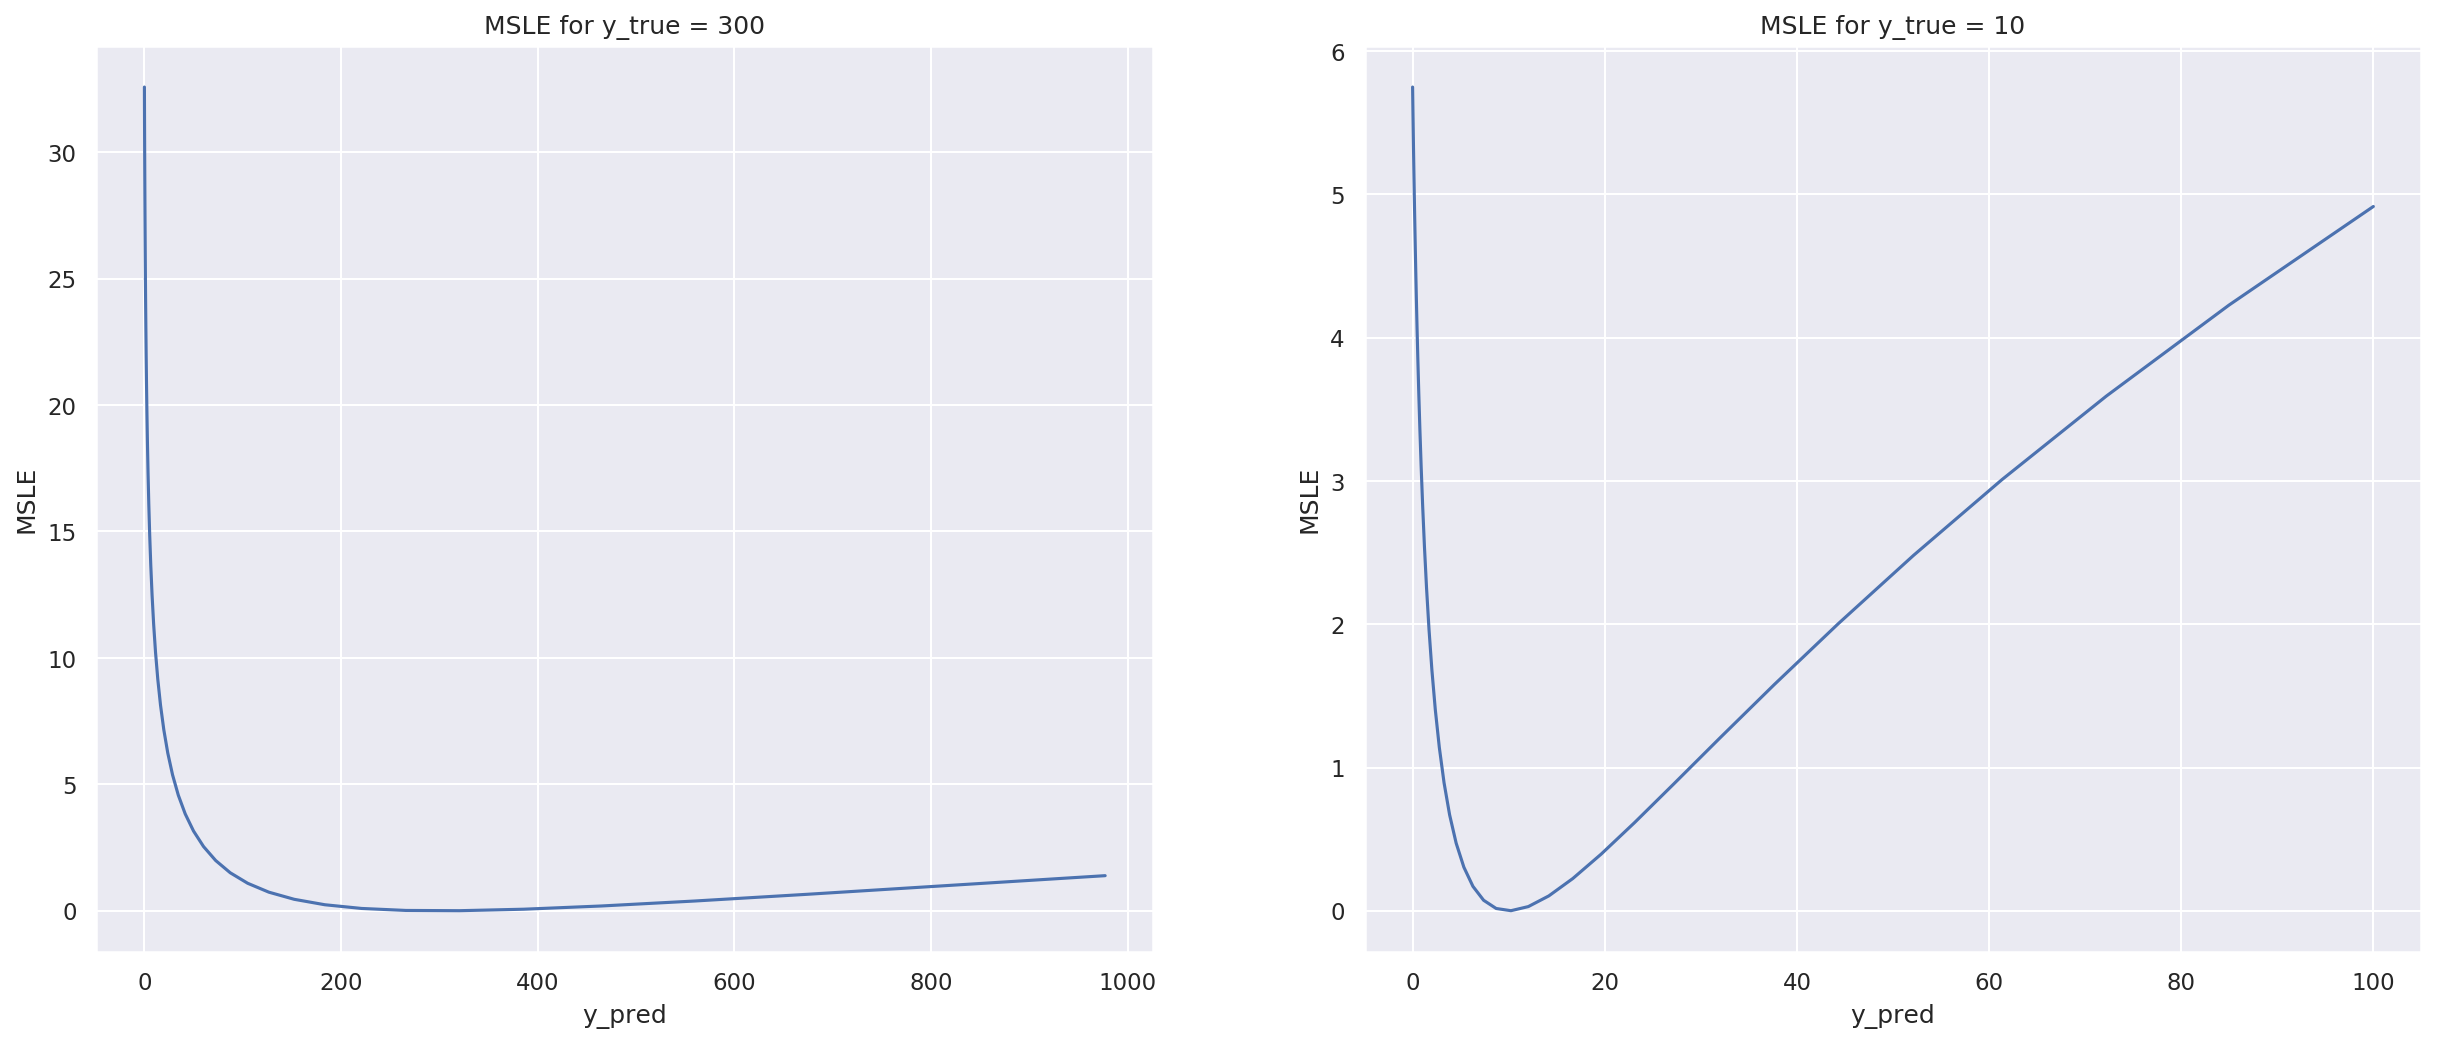

In [26]:
x = [10 ** (i) for i in np.linspace(-5, 2.99, 100)]
x_2 = [10 ** (i) for i in np.linspace(-5, 2, 100)]
y_300 = [(np.log((300 + 1) / (x_i + 1))) ** 2 for x_i in x]
y_10 = [(np.log((10 + 1) / (x_i + 1))) ** 2 for x_i in x_2]

fig, axs = plt.subplots(1, 2, figsize=(20, 8), dpi=150)
axs[0].plot(x, y_300)
axs[0].set_xlabel("y_pred")
axs[0].set_ylabel("MSLE")
axs[0].set_title("MSLE for y_true = 300")

axs[1].plot(x_2, y_10)
axs[1].set_xlabel("y_pred")
axs[1].set_ylabel("MSLE")
axs[1].set_title("MSLE for y_true = 10")

fig.savefig("./Results/MSLE_Effect.png")

In [15]:
# Split the Training set into a Training and a Validation sets
X_train_split, X_val, y_train_split, y_val = mod_selec.train_test_split(X_train, y_train,
                                                                        test_size=0.3,
                                                                        random_state=42)

In [30]:
# Definition of the model
model = Sequential()

# Dense Layer
# model.add(BatchNormalization())
model.add(Dense(16, activation="relu", input_shape=(len(X_train[0]), )))
# model.add(Dropout(0.25))
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu"))
# # model.add(Dropout(0.25))
model.add(Dense(1, activation="relu"))

# Definiton of the optimizer
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Definition of the loss function
model.compile(loss='mean_squared_logarithmic_error', optimizer="adam")

# Fitting of the model
model.fit(X_train, y_train, epochs=7, batch_size=64, verbose=1)

Epoch 1/7
695255/695255 [==============================] - 15s 22us/step - loss: 0.1460
Epoch 2/7
695255/695255 [==============================] - 15s 21us/step - loss: 0.1095
Epoch 3/7
695255/695255 [==============================] - 15s 21us/step - loss: 0.1046
Epoch 4/7
695255/695255 [==============================] - 15s 21us/step - loss: 0.1016
Epoch 5/7
695255/695255 [==============================] - 15s 21us/step - loss: 0.1000
Epoch 6/7
695255/695255 [==============================] - 15s 21us/step - loss: 0.0984
Epoch 7/7
695255/695255 [==============================] - 15s 21us/step - loss: 0.0975


In [ ]:
errors_df = X_train_df.filter(regex='value_*', axis = 1)
errors_df["pred"] = model.predict(X_train)
errors_df["true"] = Y_train_df.loc[:, "value"]
errors_df["errors"] = (np.log((errors_df["pred"] + 1) / (errors_df["true"] + 1)) ** 2)
errors_df.sort_values("errors", ascending=False, inplace=True)
errors_df.head(10)

In [31]:
# Make predictions
y_pred_values = model.predict(X_test)

# Clip the predictions to be positives
y_pred_values = np.where(y_pred_values < 0, 0, y_pred_values)

# Disaply the scores
print("Score on the training set: ", metrics.mean_squared_log_error(y_train,
                                                                    model.predict(X_train)))

# Save predictions
Y_pred_df = X_test_df.ID.to_frame()
Y_pred_df["value"] = y_pred_values
Y_pred_df.to_csv("./Results/Predictions_NN.csv", index=False)

Score on the training set:  0.09591772471884955


# 6 - LightGbm

## 6.1 - Cross-Validation of the model

In [ ]:
stats_id = np.unique(X_train_df["station_id"].values)
stats_groups = np.random.permutation(stats_id).reshape((5, -1))

l_train, l_val = [], []

for i in range(5):
    
    l_val.append(stats_groups[i])
    l_train.append(np.setdiff1d(stats_id, stats_groups[i]))

In [ ]:
# Parameters of the model
params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'root_mean_squared_error',
        'max_depth': 5, 
        'num_leaves': 25,
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5
    }

# Cross-Validation
l_train_acc, l_val_acc = [], []

for i in range(5):
    
    X_train_split_df = X_train_df[X_train_df.station_id.isin(l_train[i])].reset_index(drop=True)
    X_val_df = X_train_df[X_train_df.station_id.isin(l_val[i])].reset_index(drop=True)
    
    X_train_split = X_train_split_df.values
    y_train_split = Y_train_df[X_train_df.station_id.isin(l_train[i])].reset_index(drop=True)["value"].values

    X_val = X_val_df.values
    y_val = Y_train_df[X_train_df.station_id.isin(l_val[i])].reset_index(drop=True)["value"].values
    
    lgb_train = lgb.Dataset(X_train_split, y_train_split)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets = [lgb_eval],
                    num_boost_round = 10000,
                    early_stopping_rounds = 200)
    
    train_preds = gbm.predict(X_train_split)
    l_train_acc.append(metrics.mean_squared_log_error(y_train_split, train_preds))
    
    val_preds = gbm.predict(X_val)
    l_val_acc.append(metrics.mean_squared_log_error(y_val, val_preds))

In [ ]:
# Display the scores obtained
print("Train acc: ", l_train_acc)
print("Val acc: ", l_val_acc)

## 6.2 - Make Predictions

In [ ]:
# Final parameters
model_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'max_depth': 5, 
        'num_leaves': 25,
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5
    }

# Fitting of the model
lgb_train = lgb.Dataset(X_train, y_train)
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round = 500)

# Computation of the predictions
y_pred_values = gbm.predict(X_test)

# Clip the predictions to be positives
y_pred_values = np.where(y_pred_values < 0, 0, y_pred_values)

# Disaply the scores
print("Score on the training set: ", metrics.mean_squared_log_error(y_train,
                                                                    gbm.predict(X_train)))

# Save predictions
Y_pred_df = X_test_df.ID.to_frame()
Y_pred_df["value"] = y_pred_values
Y_pred_df.to_csv("./Results/Predictions_LightGBM.csv", index=False)